In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import itertools
import glob

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [5]:
import matplotlib.dates as dates
from scipy import stats
import pingouin as pg
from scipy.stats import variation
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
import itertools

/home/srj34/jupyter-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [6]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [7]:
label_fontsize = 16
title_fontsize = 16

In [8]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [9]:
sns.set(font_scale=1.25, style="whitegrid")

In [10]:
%%R
#devtools::install_github("danilinares/quickpsy")

NULL


In [11]:
%%R
library("ggplot2")
library("quickpsy")
library("dplyr")
library("tidyr")
library("BayesFactor")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: coda

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: ************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



In [12]:
%%R
basepath = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
behfilepath = "decAlertnessDecisionmaking_JNeuroscience2021/beh_data/csv_files/"

In [13]:
%%R
#read the csv file first (created by process_psychophysics)
csvfile = paste(basepath,behfilepath,"psychophysics.csv",sep="")
myoveralldata = read.csv(csvfile) # read csv file

In [14]:
%%R
head(myoveralldata)

  subj_idx stim leftresp rightresp totresp state
1        2  -60        2         0       2 Alert
2        2  -55        2         0       2 Alert
3        2  -50        2         0       2 Alert
4        2  -45        4         0       4 Alert
5        2  -40        2         0       2 Alert
6        2  -35        4         0       4 Alert


In [15]:
%%R
subj_idxs = unique(myoveralldata$subj_idx)
print(subj_idxs)

 [1]  2  4  5  6  7  9 10 20 21 22 23 24 25 26 27 28 30 31 32 33 34 35 36 37 38
[26] 39 41 42 43 44 45 46


In [16]:
%%R
listidx <- seq(1, length(subj_idxs))

In [17]:
%%R
# the shared parameter is p[2], which is same slope..
sameslope_fun <- tibble(state = c("Alert", "Drowsy"),
                   fun = c(function(x, p) pnorm(x, p[1], p[2]),
                           function(x, p) pnorm(x, p[3], p[2])))
                           
sameslope_fit <- quickpsy(myoveralldata, stim, rightresp, totresp,
                  grouping = c("subj_idx", "state"),
                  fun = sameslope_fun,
                  parini = c(-20, 0, -20),
                  bootstrap = "none")

In [18]:
%%R
sameslopefit_df = pivot_wider(data = sameslope_fit$par, names_from = parn, values_from = par)
sameslopefit_df <- rename(sameslopefit_df,c("alertmean" = "p1", "slope"= "p2", "drowsymean"= "p3"))

In [19]:
%%R
tmp_idx = which(abs(sameslopefit_df$alertmean)>60,)
sameslopefit_df[tmp_idx,"alertmean"] = NA

tmp_idx = which(abs(sameslopefit_df$drowsymean)>60,)
sameslopefit_df[tmp_idx,"drowsymean"] = NA

tmp_idx = which(sameslopefit_df$slope>30,)
sameslopefit_df[tmp_idx,"slope"] = NA

In [20]:
%%R
head(sameslopefit_df)

# A tibble: 6 × 4
# Groups:   subj_idx [6]
  subj_idx alertmean slope drowsymean
     <dbl>     <dbl> <dbl>      <dbl>
1        2    -4.37   19.3     -9.79 
2        4     9.07   19.2     10.9  
3        5     3.46   23.3    -11.4  
4        6    -0.963  21.9     -3.90 
5        7     2.94   16.5      0.828
6        9     0.980  NA       23.9  


In [21]:
%%R
# different mean and different slope..
diffslopemean_fun <- tibble(state = c("Alert", "Drowsy"),
                            fun = c(function(x, p) pnorm(x, p[1], p[2]),
                                    function(x, p) pnorm(x, p[3], p[4])))

diffslopemean_fit <- quickpsy(myoveralldata, stim, rightresp, totresp,
                  grouping = c("subj_idx", "state"),
                  fun = diffslopemean_fun,
                  parini = c(-60, 60, -60, 60),
                  bootstrap = "none")

In [22]:
%%R
diffslopemeanfit_df = pivot_wider(data = diffslopemean_fit$par, names_from = parn, values_from = par)
diffslopemeanfit_df <- rename(diffslopemeanfit_df,c("alertmean" = "p1", "alertslope"= "p2", 
                                                    "drowsymean" = "p3","drowsyslope"= "p4"))

In [23]:
%%R
tmp_idx = which(abs(diffslopemeanfit_df$alertmean)>60,)
diffslopemeanfit_df[tmp_idx,"alertmean"] = NA

tmp_idx = which(abs(diffslopemeanfit_df$drowsymean)>60,)
diffslopemeanfit_df[tmp_idx,"drowsymean"] = NA

tmp_idx = which(diffslopemeanfit_df$alertslope>30,)
diffslopemeanfit_df[tmp_idx,"alertslope"] = NA

tmp_idx = which(diffslopemeanfit_df$drowsyslope>30,)
diffslopemeanfit_df[tmp_idx,"drowsyslope"] = NA

In [24]:
%%R
modeleval_likelihood = model_selection_lrt(sameslope_fit$logliks, diffslopemean_fit$logliks)
modeleval_aic = model_selection_aic(sameslope_fit$aic, diffslopemean_fit$aic)
model_comp <- data.frame(subj_idx = modeleval_aic$subj_idx, best_model = modeleval_aic$best)
modelcomp_df = left_join(model_comp, sameslopefit_df[,c("subj_idx")])
modelcomp_df = left_join(modelcomp_df, diffslopemeanfit_df[,c("subj_idx")])
modelcomp_df[] <- lapply(modelcomp_df, as.character)
modelcomp_df$best_model[modelcomp_df$best_model == "first"] = 'meanonly'
modelcomp_df$best_model[modelcomp_df$best_model == "second"] = 'meanslope'

R[write to console]: Joining, by = "subj_idx"

R[write to console]: Joining, by = "subj_idx"



In [25]:
%%R
cat("The different mean and same slope model wins in      : ", sum(modelcomp_df$best_model == 'meanonly'))
cat("\nThe different mean and different slope model wins in : ", sum(modelcomp_df$best_model == 'meanslope'))

The different mean and same slope model wins in      :  9
The different mean and different slope model wins in :  23

In [26]:
%%R
stats_df = data.frame(diffslopemeanfit_df)
stats_df$meandiff = stats_df$alertmean - stats_df$drowsymean
knitr::kable(stats_df)



| subj_idx|   alertmean| alertslope|  drowsymean| drowsyslope|    meandiff|
|--------:|-----------:|----------:|-----------:|-----------:|-----------:|
|        2|  -2.7070435|  3.8817067| -10.5402626|   23.452981|   7.8332192|
|        4|   6.1004463|  6.0072335|  11.2855294|   21.055494|  -5.1850830|
|        5|   3.2395215| 14.3735308| -11.7395828|   25.215496|  14.9791043|
|        6|  -0.8427606|  9.6860882|  -3.8729066|   24.336007|   3.0301460|
|        7|   2.0722985|  6.4569293|   0.9155914|   18.340378|   1.1567071|
|        9|   0.3558237|  6.6061451|  32.6033719|          NA| -32.2475482|
|       10|   4.5457121|  4.2695175|   0.3455658|    3.566889|   4.2001463|
|       20|  -1.5694031|  8.1908768| -10.5413725|   18.357517|   8.9719693|
|       21|  -5.0985331| 10.0861551|  -6.5900040|          NA|   1.4914708|
|       22|   7.6394990|  0.4788658|   7.1346768|    0.130583|   0.5048221|
|       23|  -0.4832121| 12.3084183|   4.8689875|   23.129402|  -5.3521996|
|       24

In [27]:
%%R
leftshift = sum(stats_df$meandiff>0, na.rm = TRUE)
rightshift = sum(stats_df$meandiff<0, na.rm = TRUE)
NAshift = sum(is.na(stats_df$meandiff), na.rm = TRUE)

In [28]:
%%R
leftshiftidx = stats_df$meandiff>0 & !is.na(stats_df$meandiff)
rightshiftidx = stats_df$meandiff<0 & !is.na(stats_df$meandiff)
NAshiftidx = is.na(stats_df$meandiff)
leftshift_subj = stats_df$subj_id[leftshiftidx]
rightshift_subj = stats_df$subj_id[rightshiftidx]
NAshift_subj = stats_df$subj_id[NAshiftidx]
cat("\nLeftshifting subjects: ", leftshift_subj)
cat("\nRightshifting subjects: ", rightshift_subj)
cat("\nNAshifting subjects: ", NAshift_subj)


Leftshifting subjects:  2 5 6 7 10 20 21 22 25 26 27 28 30 31 33 34 35 36 37 39 42 43 44 45 46
Rightshifting subjects:  4 9 23 38
NAshifting subjects:  24 32 41

In [29]:
%%R
completestats_df = stats_df[complete.cases(stats_df), ]
print(completestats_df)
print(dim(completestats_df))

   subj_idx  alertmean   alertslope  drowsymean drowsyslope   meandiff
1         2 -2.7070435 3.881707e+00 -10.5402626   23.452981  7.8332192
2         4  6.1004463 6.007233e+00  11.2855294   21.055494 -5.1850830
3         5  3.2395215 1.437353e+01 -11.7395828   25.215496 14.9791043
4         6 -0.8427606 9.686088e+00  -3.8729066   24.336007  3.0301460
5         7  2.0722985 6.456929e+00   0.9155914   18.340378  1.1567071
7        10  4.5457121 4.269517e+00   0.3455658    3.566888  4.2001463
8        20 -1.5694031 8.190877e+00 -10.5413725   18.357517  8.9719693
10       22  7.6394990 4.788658e-01   7.1346768    0.130583  0.5048221
11       23 -0.4832121 1.230842e+01   4.8689875   23.129402 -5.3521996
13       25 -1.7372839 1.624877e+01  -4.4548721   12.233323  2.7175882
14       26  1.0944181 1.950420e+01  -9.7253543   23.615855 10.8197724
15       27  4.9997823 4.677116e-06 -11.9461540   13.551654 16.9459364
16       28 -8.3339401 1.824905e+01 -15.4355021   23.368767  7.1015621
17    

In [30]:
%%R
print(cor.test(abs(completestats_df$alertmean),completestats_df$alertslope))
print(cor.test(abs(completestats_df$drowsymean),completestats_df$drowsyslope))


	Pearson's product-moment correlation

data:  abs(completestats_df$alertmean) and completestats_df$alertslope
t = -0.3253, df = 17, p-value = 0.7489
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5144822  0.3894704
sample estimates:
        cor 
-0.07865261 


	Pearson's product-moment correlation

data:  abs(completestats_df$drowsymean) and completestats_df$drowsyslope
t = 1.5079, df = 17, p-value = 0.1499
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1312117  0.6900281
sample estimates:
      cor 
0.3434674 



In [31]:
%%R
diffslopemean_fit$curves

# A tibble: 32,000 × 4
# Groups:   subj_idx, state [64]
   subj_idx state     x        y
      <dbl> <chr> <dbl>    <dbl>
 1        2 Alert -60   1.33e-49
 2        2 Alert -59.8 3.33e-49
 3        2 Alert -59.5 8.30e-49
 4        2 Alert -59.3 2.06e-48
 5        2 Alert -59.0 5.09e-48
 6        2 Alert -58.8 1.25e-47
 7        2 Alert -58.6 3.08e-47
 8        2 Alert -58.3 7.52e-47
 9        2 Alert -58.1 1.83e-46
10        2 Alert -57.8 4.44e-46
# … with 31,990 more rows


In [32]:
%%R
myplotdata = data.frame(diffslopemean_fit$curves)
head(myplotdata)

  subj_idx state         x            y
1        2 Alert -60.00000 1.331656e-49
2        2 Alert -59.75952 3.330335e-49
3        2 Alert -59.51904 8.297065e-49
4        2 Alert -59.27856 2.059216e-48
5        2 Alert -59.03808 5.091197e-48
6        2 Alert -58.79760 1.253946e-47


In [33]:
%%R
myplotalert = myplotdata[myplotdata$state == 'Alert',]
myplotdrowsy = myplotdata[myplotdata$state == 'Drowsy',]

In [34]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [35]:
df_myoveralldata = robjects.r('myoveralldata')
df_myplotdata = robjects.r('myplotdata')
df_alert = robjects.r('myplotalert')
df_drowsy = robjects.r('myplotdrowsy')
df_stats = robjects.r('stats_df[listidx,]')
df_rightshifter = robjects.r('rightshift_subj')
df_leftshifter = robjects.r('leftshift_subj')
df_leftshiftnums = robjects.r('leftshift')
df_rightshiftnums = robjects.r('rightshift')
df_NAshiftnums = robjects.r('NAshift')

In [36]:
df_rightshifter = np.asfarray(df_rightshifter,float)
df_leftshifter = np.asfarray(df_leftshifter,float)

In [37]:
df_alert

,subj_idx,state,x,y
1,2.0,Alert,-60.000000,1.331656e-49
2,2.0,Alert,-59.759519,3.330335e-49
3,2.0,Alert,-59.519038,8.297065e-49
4,2.0,Alert,-59.278557,2.059216e-48
5,2.0,Alert,-59.038076,5.091197e-48
...,...,...,...,...
31496,46.0,Alert,59.038076,1.000000e+00
31497,46.0,Alert,59.278557,1.000000e+00
31498,46.0,Alert,59.519038,1.000000e+00
31499,46.0,Alert,59.759519,1.000000e+00


In [38]:
group_df = pd.concat([df_alert,df_drowsy],axis=0, sort=False)

In [39]:
group_df

,subj_idx,state,x,y
1,2.0,Alert,-60.000000,1.331656e-49
2,2.0,Alert,-59.759519,3.330335e-49
3,2.0,Alert,-59.519038,8.297065e-49
4,2.0,Alert,-59.278557,2.059216e-48
5,2.0,Alert,-59.038076,5.091197e-48
...,...,...,...,...
31996,46.0,Drowsy,59.038076,9.989992e-01
31997,46.0,Drowsy,59.278557,9.990325e-01
31998,46.0,Drowsy,59.519038,9.990648e-01
31999,46.0,Drowsy,59.759519,9.990960e-01


In [40]:
group_alertmean = df_alert.groupby(['x']).mean()
group_alertmean = group_alertmean.drop(columns = 'subj_idx')
group_alertmean.index.name = 'xseq'
group_alertmean.reset_index(inplace=True)
group_alertmean = group_alertmean.rename(columns={'y': 'yseq_alertmean'})
group_alertmean

,xseq,yseq_alertmean
0,-60.000000,0.005046
1,-59.759519,0.005142
2,-59.519038,0.005240
3,-59.278557,0.005340
4,-59.038076,0.005442
...,...,...
495,59.038076,0.992474
496,59.278557,0.992545
497,59.519038,0.992615
498,59.759519,0.992685


In [41]:
group_drowsymean = df_drowsy.groupby(['x']).mean()
group_drowsymean = group_drowsymean.drop(columns = 'subj_idx')
group_drowsymean.index.name = 'xseq'
group_drowsymean.reset_index(inplace=True)
group_drowsymean = group_drowsymean.rename(columns={'y': 'yseq_drowsymean'})
group_drowsymean

,xseq,yseq_drowsymean
0,-60.000000,0.128481
1,-59.759519,0.129125
2,-59.519038,0.129774
3,-59.278557,0.130428
4,-59.038076,0.131086
...,...,...
495,59.038076,0.955914
496,59.278557,0.956136
497,59.519038,0.956357
498,59.759519,0.956575


In [42]:
import rpy2.robjects as ro

from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
  r_group_alertmean = ro.conversion.py2rpy(group_alertmean)

with localconverter(ro.default_converter + pandas2ri.converter):
  r_group_drowsymean = ro.conversion.py2rpy(group_drowsymean)

with localconverter(ro.default_converter + pandas2ri.converter):
  r_group_df = ro.conversion.py2rpy(group_df)

In [43]:
robjects.globalenv["r_group_alertmean"] = r_group_alertmean
robjects.globalenv["r_group_drowsymean"] = r_group_drowsymean
robjects.globalenv["r_group_df"] = r_group_df

In [44]:
pal = {state: "b" if state == 'Drowsy' else "r" for state in group_df.state.unique()}

In [45]:
base_dir = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/'
output_dir = 'decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

In [46]:
fig_dir = base_dir + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

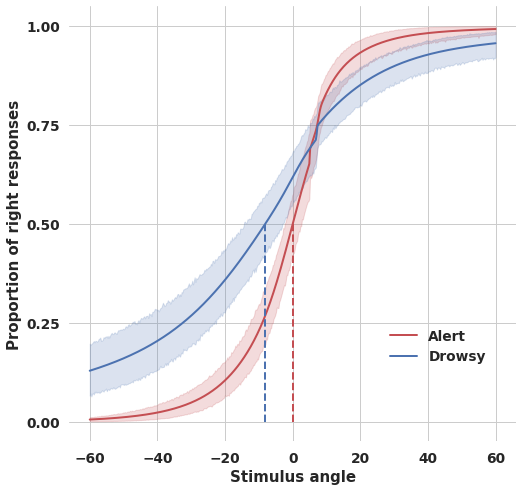

In [47]:
f, (ax1) = plt.subplots(figsize=(8, 8))

ax2 = sns.lineplot(x="x",y="y",hue='state',data=group_df,ax=ax1, 
                    markers=False, style="state", dashes=False,
                    palette=pal,linewidth = 2);

alertmean_val = 0 #manually calculated as the fits are made on indiv subjects and just averaged here..
x1 = [alertmean_val, 
      alertmean_val]
y1 = [0, 0.5]
ax1.plot(x1, y1,'--r', linewidth=2)

drowsymean_val = -8.3 #manually calculated as the fits are made on indiv subjects and just averaged here..
x1 = [drowsymean_val, 
      drowsymean_val]
y1 = [0, 0.5]
ax1.plot(x1, y1,'--b', linewidth=2)

ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_xlabel('Stimulus angle')
ax1.set_ylabel('Proportion of right responses')

ax1.legend(['Alert','Drowsy'],loc='lower left', bbox_to_anchor=(0.69, 0.15),framealpha=0.0)

tmpval = ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])

tmpval = ax1.set_xticks(np.arange(-60,70,20))
plt.box(False)
ax1.grid(True)

plt.savefig(fig_dir + "grouplevel_bias.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)

In [48]:
len(np.unique(df_myplotdata.subj_idx))

32

In [49]:
# example rightshifer: 23
# example leftshifer: 6

In [50]:
def plotsubj_biasshift(subject_id, ax, xlabel, ylabel, title):
    
    #print('processing subject: ', str(subject_id))
    
    # alert data plot..
    plotdata = df_myoveralldata[(df_myoveralldata.state=='Alert') &\
                                (df_myoveralldata.subj_idx==subject_id)]
    
    plotdata['p_right'] = plotdata['rightresp'] / plotdata['totresp']
    
    size = np.asarray(plotdata['totresp'])
    stim = np.asarray(plotdata['stim'])
    p_right = np.asarray(plotdata['p_right'])
    
    plotdf_alert = df_alert[df_alert.subj_idx==subject_id]
    xseq = np.asarray(plotdf_alert['x'])
    yseq = np.asarray(plotdf_alert['y'])
    
    
    ax.scatter(stim ,p_right, marker="o", s = 1000*size/np.sum(size), alpha=0.8,
                         color = 'r',edgecolors = 'k',linewidths = 2)
    
    
    ax.plot(xseq, yseq, '-r',alpha=0.5, linewidth=3);
    
    
    # drowsy data plot..
    plotdata = df_myoveralldata[(df_myoveralldata.state=='Drowsy') &\
                                (df_myoveralldata.subj_idx==subject_id)]
    
    plotdata['p_right'] = plotdata['rightresp'] / plotdata['totresp']
    size = np.asarray(plotdata['totresp'])
    stim = np.asarray(plotdata['stim'])
    p_right = np.asarray(plotdata['p_right'])

    plotdf_drowsy = df_drowsy[df_drowsy.subj_idx==subject_id]
    xseq = np.asarray(plotdf_drowsy['x'])
    yseq = np.asarray(plotdf_drowsy['y'])

    ax.scatter(stim ,p_right, marker="o", s = 1000*size/np.sum(size), alpha=0.8,
                  color = 'b',edgecolors = 'k',linewidths = 2)
    
    ax.plot(xseq, yseq, '-b',alpha=0.5, linewidth=3)
    
    # legend, mid-line plots..
    ax.legend(['Alert','Drowsy'],loc='lower left', bbox_to_anchor=(0.69, 0.15),framealpha=0.0)

    x1 = [float(df_stats[df_stats.subj_idx==float(subject_id)].alertmean), 
          float(df_stats[df_stats.subj_idx==float(subject_id)].alertmean)]
    y1 = [0, 0.5]
    ax.plot(x1, y1,'--r', linewidth=2)

    x1 = [float(df_stats[df_stats.subj_idx==float(subject_id)].drowsymean), 
          float(df_stats[df_stats.subj_idx==float(subject_id)].drowsymean)]
    y1 = [0, 0.5]
    ax.plot(x1, y1,'--b', linewidth=2)

    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.set_frame_on(False)
    ax.set_title(title,fontsize=label_fontsize, weight = 'bold')
    

In [51]:
subjects = ['02','04','05','06','07','09','10','20','21','22',\
            '23','24','25','26','27','28','30','31','32','33',\
            '34','35','36','37','38','39','41','42','43','44',\
            '45','46']

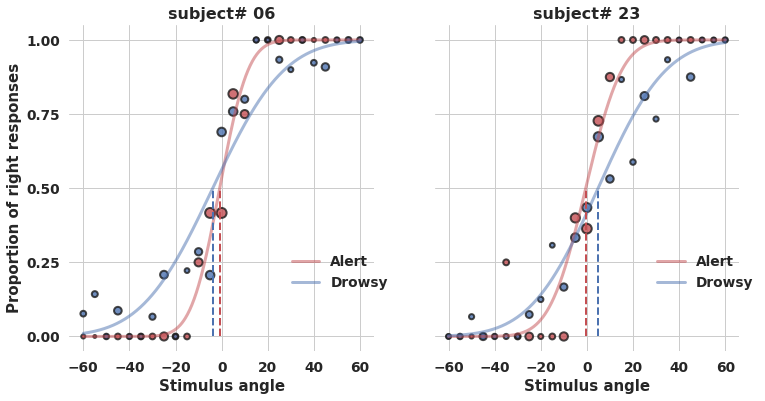

In [52]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12, 6))
plotsubj_biasshift(subject_id = int(subjects[3]), ax = ax[0], xlabel = 'Stimulus angle', 
                   ylabel = 'Proportion of right responses', title = 'subject#' + ' ' + subjects[3])
plotsubj_biasshift(subject_id = int(subjects[10]), ax = ax[1], xlabel = 'Stimulus angle', 
                   ylabel = '', title = 'subject#' + ' ' + subjects[10])
plt.savefig(fig_dir + "shifters.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)

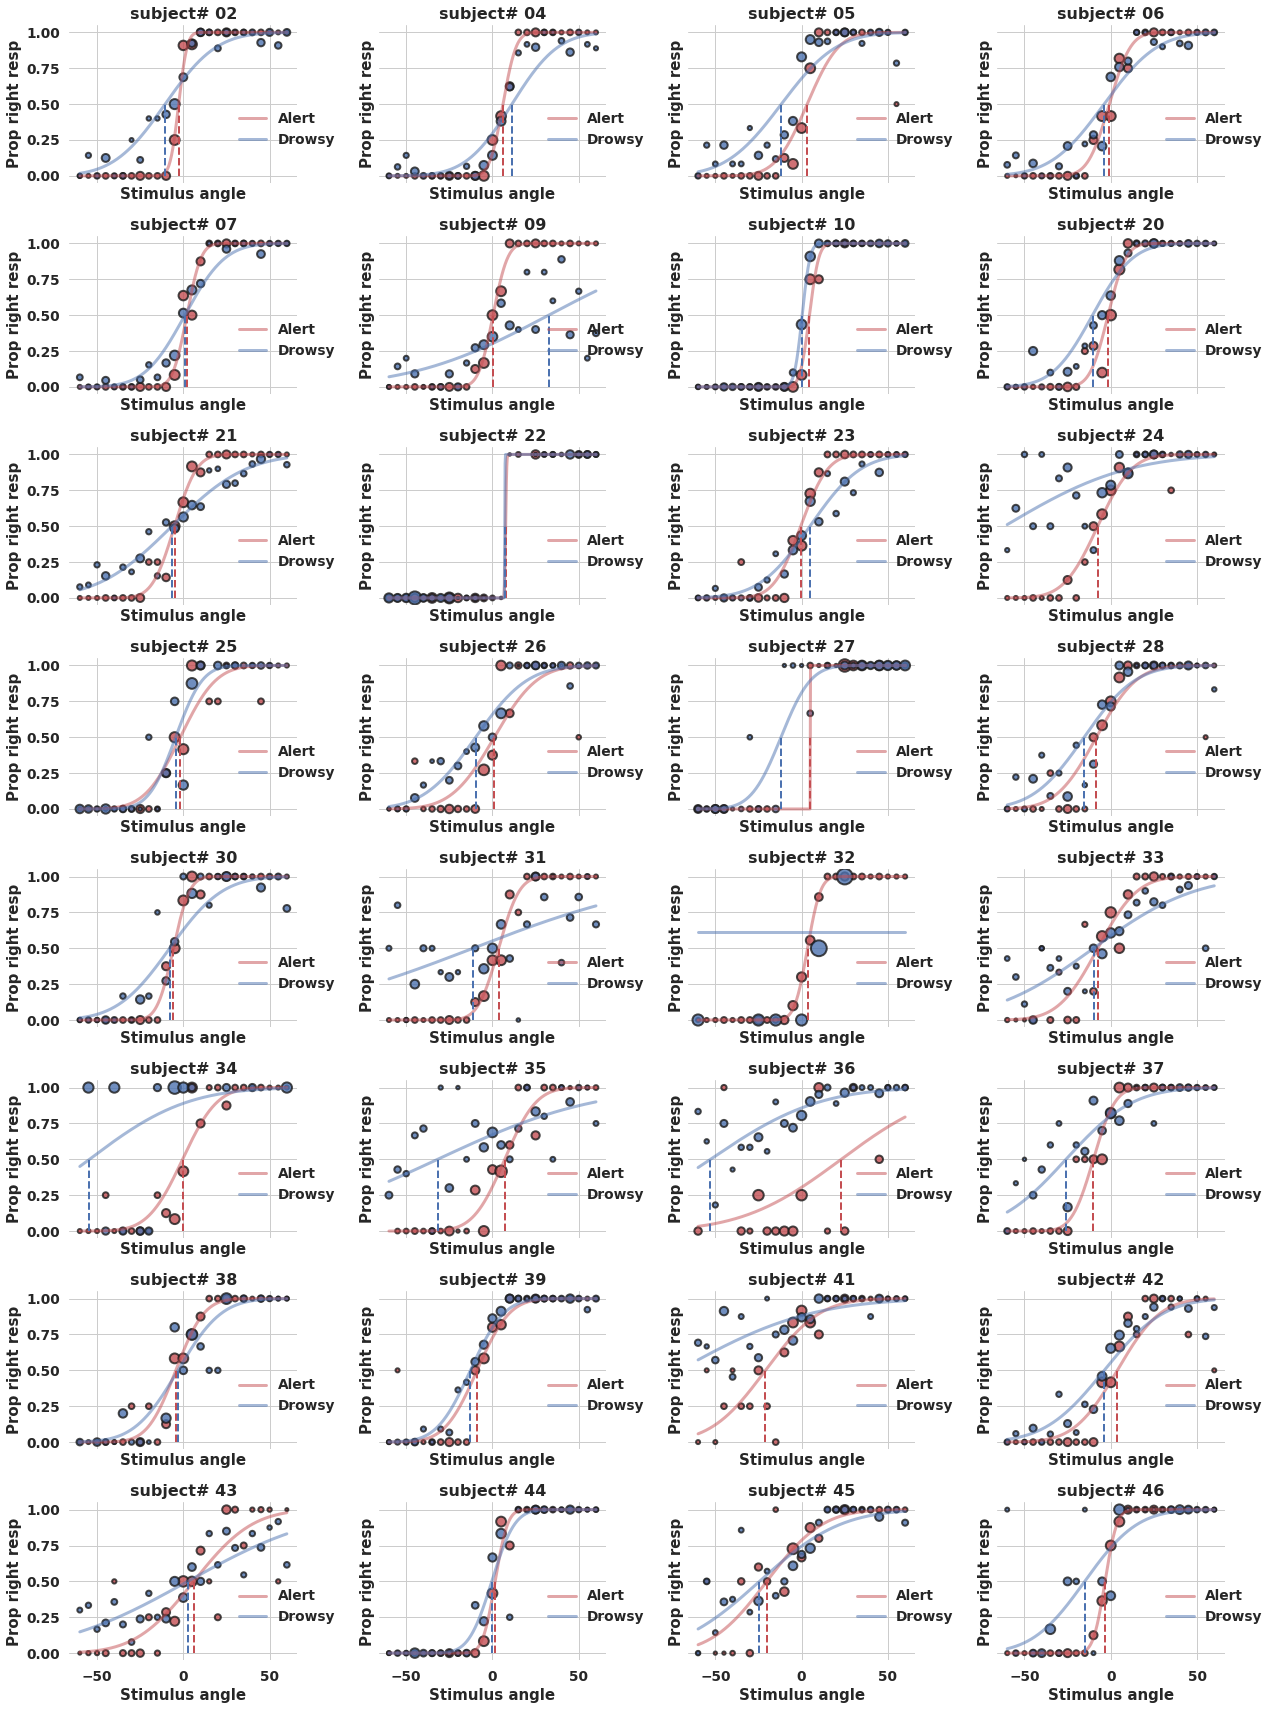

In [53]:
tPlot, axes = plt.subplots(figsize=(18, 24),
        nrows=8, ncols=4, sharex=True, sharey=True)

for s, subject in enumerate(subjects):  # Loop across each subject
        rowidx = s//4
        colidx = s%4
        titlestr = 'subject#' + ' ' + subject
        plotsubj_biasshift(subject_id = int(subject), ax = axes[rowidx,colidx], xlabel = 'Stimulus angle', 
                   ylabel = 'Prop right resp', title = titlestr)
        
plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.savefig(fig_dir + "suppl_shifters_allsubject.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)

In [54]:
alldf_stats = df_stats.copy()

In [55]:
alldf_stats.subj_idx.unique()

array([ 2.,  4.,  5.,  6.,  7.,  9., 10., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       41., 42., 43., 44., 45., 46.])

In [56]:
df_stats = alldf_stats.dropna()
df_stats.subj_idx.unique()

array([ 2.,  4.,  5.,  6.,  7., 10., 20., 22., 23., 25., 26., 27., 28.,
       30., 38., 39., 42., 44., 46.])

In [57]:
ignored_subjs = set(alldf_stats.subj_idx.unique()) ^ set(df_stats.subj_idx.unique())
ignored_subjs = list(ignored_subjs)
ignored_subjs = list(map(int, ignored_subjs))
print('Ignored subjects are:', np.sort(ignored_subjs))

Ignored subjects are: [ 9 21 24 31 32 33 34 35 36 37 41 43 45]


In [58]:
print('alertmean: ' ,df_stats['alertmean'].mean())
print('drowsymean: ' ,df_stats['drowsymean'].mean())

alertmean:  -0.15270636724925624
drowsymean:  -5.090584254887543


In [59]:
df_stats

,subj_idx,alertmean,alertslope,drowsymean,drowsyslope,meandiff
1,2.0,-2.707043,3.881707,-10.540263,23.452981,7.833219
2,4.0,6.100446,6.007233,11.285529,21.055494,-5.185083
3,5.0,3.239522,14.373531,-11.739583,25.215496,14.979104
4,6.0,-0.842761,9.686088,-3.872907,24.336007,3.030146
5,7.0,2.072299,6.456929,0.915591,18.340378,1.156707
7,10.0,4.545712,4.269517,0.345566,3.566888,4.200146
8,20.0,-1.569403,8.190877,-10.541372,18.357517,8.971969
10,22.0,7.639499,0.478866,7.134677,0.130583,0.504822
11,23.0,-0.483212,12.308418,4.868988,23.129402,-5.352200
13,25.0,-1.737284,16.248773,-4.454872,12.233323,2.717588


In [60]:
res_mean = pg.ttest(df_stats['alertmean'],df_stats['drowsymean'], paired = True, correction='auto')
res_mean

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.526874,18,two-sided,0.002409,"[2.0, 7.88]",0.776327,17.322,0.892267


In [61]:
res_slope = pg.ttest(df_stats['alertslope'],df_stats['drowsyslope'], paired = True, correction='auto')
res_slope

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-5.521162,18,two-sided,0.00003,"[-12.03, -5.4]",1.267777,809.371,0.999429


In [62]:
df1 = pd.DataFrame({'Condition' : 'Alert', 'mean': df_stats.alertmean, 'subjects': df_stats.subj_idx})
df2 = pd.DataFrame({'Condition' : 'Drowsy', 'mean': df_stats.drowsymean, 'subjects': df_stats.subj_idx})
df_biasshift = pd.concat([df1,df2])

In [63]:
df1 = pd.DataFrame({'Condition' : 'Alert', 'slope': df_stats.alertslope, 'subjects': df_stats.subj_idx})
df2 = pd.DataFrame({'Condition' : 'Drowsy', 'slope': df_stats.drowsyslope, 'subjects': df_stats.subj_idx})
df_slopeshift = pd.concat([df1,df2])

In [64]:
df_biasshift.Condition.unique()

array(['Alert', 'Drowsy'], dtype=object)

In [65]:
pal = {Condition: "b" if Condition == 'Drowsy' else "r" for Condition in df_biasshift.Condition.unique()}

In [66]:
def statannotation(ax, x1, x2, y,text):
    h = 0.5
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

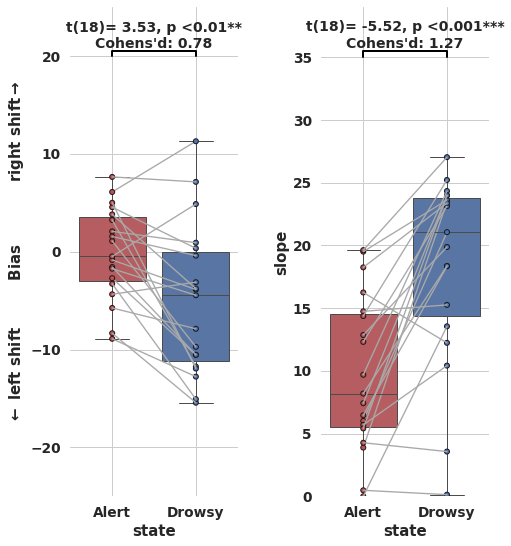

In [67]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(3.75*2, 9))

ax3 = sns.pointplot(x="Condition",y="mean",hue='subjects',data=df_biasshift,ax=ax1, dodge=0.0, scale = 0.5, 
                    palette=['darkgray'],markers = '', linewidth = 0.15)

sns.boxplot(x="Condition", y="mean", data=df_biasshift, whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True,palette=pal,linewidth=1)
sns.stripplot(x="Condition", y="mean", data=df_biasshift,jitter=False, linewidth=1, ax=ax1,
              edgecolor ="k",palette=pal)

ax1.legend_.remove()


# left,rightshifters annotation
x = -0.4
y = 17.5
col = 'k' 


string_val = 't(' + str(np.round(res_mean['dof'].values[0],2)) + ')= ' + \
             str(np.round(res_mean['T'].values[0],2)) + \
             ', p' + ' <0.01**' + "\nCohens'd: " + str(np.round(res_mean['cohen-d'].values[0],2))

statannotation(ax = ax1, x1 = 0, x2 = 1, y = 20, text = string_val)


ax1.set_ylim(-25, 25)
ax1.set_ylabel(r'$\leftarrow$ left shift         Bias            right shift$\rightarrow$', 
           fontweight = 'bold', rotation=90)

ax1.set_xlabel('state')
ax1.grid(True)



ax4 = sns.pointplot(x="Condition",y="slope",hue='subjects',data=df_slopeshift,ax=ax2, dodge=0.0, scale = 0.5, 
                    palette=['darkgray'],markers = '', linewidth = 0.15)

sns.boxplot(x="Condition", y="slope", data=df_slopeshift, whis=np.inf, ax=ax2, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True,palette=pal,linewidth=1)
sns.stripplot(x="Condition", y="slope", data=df_slopeshift,jitter=False, linewidth=1, ax=ax2,
              edgecolor ="k",palette=pal)

ax2.legend_.remove()
ax2.set_ylim(0, 39)
ax2.set_xlabel('state')
ax2.grid(True)


# bias annotation
x = -0.4
y = 33
col = 'k' 

string_val = 't(' + str(np.round(res_slope['dof'].values[0],2)) + ')= ' + \
             str(np.round(res_slope['T'].values[0],2)) + \
             ', p' + ' <0.001***' + "\nCohens'd: " + str(np.round(res_slope['cohen-d'].values[0],2))

statannotation(ax = ax2, x1 = 0, x2 = 1, y = 35, text = string_val)


# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()

ax1.set_frame_on(False)
ax2.set_frame_on(False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

plt.savefig(fig_dir + "bias_slope.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)